In [9]:
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs as ccrs
import xarray as xr
import numpy as np
from datetime import datetime

In [47]:
from G5NR_utils import SKEDot,regrid,subgrid


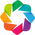

In [4]:
hv.notebook_extension('bokeh') #other backend is matplotlib but can be changed on the fly just before plottting

In [10]:
#data from ZIDV bundle
data_3d=xr.open_dataset('data_0_3D7km30minuteInst.nc')
print(data_3d.data_vars)
#remote whole dataset 
#data_3d=xr.open_dataset('http://weather.rsmas.miami.edu/repository/opendap/synth:1142722f-a386-4c17-a4f6-0f685cd19ae3:L0c1TlIvR0VPUzUtTmF0dXJlLVJ1bi1JbnN0MzBtaW4tN2ttX3ByZXNzdXJlX21ldGhvZDIubmNtbA==/entry.das')

Data variables:
    u        (time, lev, lat, lon) float64 -24.83 -24.86 -24.83 -24.64 ...
    v        (time, lev, lat, lon) float64 -14.41 -14.58 -14.73 -14.89 ...
    w        (time, lev, lat, lon) float64 0.1658 0.1758 0.1835 0.1642 ...
    airdens  (time, lev, lat, lon) float64 2.52e-05 2.52e-05 2.519e-05 ...


In [12]:
#make data selection, use .sel to select by coordinate, .isel to select by index
#use slice to select ranges 
#data_3d.sel(time=slice(datetime(2005,6,1,0,30),datetime(2005,6,1,2,30)),lat=slice(0,5),lon=slice(-14,-10))
#data_3d.isel(time=0)

In [15]:
#create a geoviews object for visualization 
#advantage with geoviews dataset vs holoviews dataset (hv.Dataset) projections, overlaying coastline is natural to geoviews  
#key
gvdataset = gv.Dataset(data_3d.u.isel(time=0)) #optionally can supply projection
print(gvdataset)

:Dataset   [lon,lat,lev]   (u)


:DynamicMap   [lev]
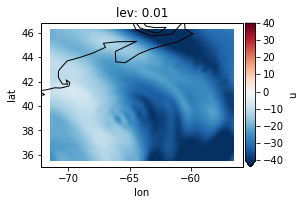

In [33]:
%%output backend='matplotlib' #backend changed to matplotlib
%%opts Image (cmap='RdBu_r') [colorbar=True] Feature.Lines (line_color='gray' line_width=0.5)
#%%output size=200 
#create a display element with coastline 
#any dimensions left out in kdims will become a widget
#redim.range((min,max)) is important to fix colorbar, it can be done at anystep from creating dataset till after plot is made 
gvdataset.redim.range(u=(-40,40)).to(gv.Image,kdims=['lon','lat'],dynamic=True)*gf.coastline 

In [44]:
%%output backend='bokeh' #backend changed to bokeh, gives more options for tooltip
%%opts Image (cmap='RdBu_r') [width=600 height=400 colorbar=True toolbar='above'] Feature.Lines (line_color='gray' line_width=0.5)
#create a holoview display element without coastline 
gvdataset.redim.range(u=(-40,40)).to(hv.Image,kdims=['lon','lat'],dynamic=True)

:DynamicMap   [lev]

In [48]:
subgrid_da=subgrid(data_3d,90,45)

In [50]:
#a more complex geoviews dataset
gv_subgrid=gv.Dataset(subgrid_da)
gv_subgrid

:Dataset   [lat,lon,lev,time]   (u,v,w,airdens,lon_bins,lat_bins)

In [43]:
%%output backend='bokeh' #backend changed to bokeh, gives more options for tooltip
%%opts Image (cmap='RdBu_r') [width=600 height=400 colorbar=True toolbar='above'] Feature.Lines (line_color='gray' line_width=0.5)
gv_subgrid.to(hv.Image,kdims=['lon','lat'],vdims=['u'],dynamic=True)

:DynamicMap   [lev,time]

In [66]:
#compose more elements
u_img=gv_subgrid.to(hv.Image,kdims=['lon','lat'],vdims=['u'],label='up',dynamic=True).redim.range(u=(-15,15))
v_img=gv_subgrid.to(hv.Image,kdims=['lon','lat'],vdims=['v'],label='vp',dynamic=True).redim.range(v=(-15,15))
w_img=gv_subgrid.to(hv.Image,kdims=['lon','lat'],vdims=['w'],label='wp',dynamic=True).redim.range(w=(-2,2))

In [68]:
%%output backend='bokeh' #backend changed to bokeh, gives more options for tooltip
%%opts Image (cmap='RdBu_r') [width=300 height=200 colorbar=True toolbar='above'] Feature.Lines (line_color='gray' line_width=0.5)
(u_img+v_img+w_img).cols(2) #+operrator is enough ,cols spcifies columns

:Layout
   .DynamicMap.Up :DynamicMap   [lev,time]
      :Image   [lon,lat]   (u)
   .DynamicMap.Vp :DynamicMap   [lev,time]
      :Image   [lon,lat]   (v)
   .DynamicMap.Wp :DynamicMap   [lev,time]
      :Image   [lon,lat]   (w)

In [179]:
def plot_skedot(nlon,nlat):
    skedot=SKEDot(data_3d.airdens.isel(time=0),data_3d.u.isel(time=0),data_3d.v.isel(time=0),data_3d.w.isel(time=0),nlon,nlat)
    gv_dataset=gv.Dataset(skedot).redim.range(SKEDOT=(-1,1))
    return hv.Image(gv_dataset)

In [181]:
glatlon={'04deg':(90,45),'02deg':(180,91),'01deg':(360,181),'05deg':(720,361)}
img_dict = {f:plot_skedot(glatlon[f][0],glatlon[f][1]) for f in glatlon}
#HoloMap is a static map, very slow to display for heavy dataset
#DynamicMap can be constructed directly from hv.DynamicMap(plot_function)
#here holomap is used because gives this dropdown widget, havent figured how to do wih dynamic map
#but before displaying holomap it is converted to a dynamicmap, so still ok to use in this case
hmap=hv.HoloMap(img_dict,kdims=['Resolution'])

In [182]:
%%output backend='bokeh'
%%opts Image (cmap='RdBu_r') [width=600 height=400 colorbar=True toolbar='above'] Feature.Lines (line_color='gray' line_width=0.5)
hv.util.Dynamic(hmap)

:DynamicMap   [Resolution]